In [1]:
import numpy as np
import gurobipy as gp

from gurobipy import *
from gurobipy import quicksum
from gurobipy import Model
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore')
from os.path import exists as file_exists

In [2]:
# Variable defined to set the stop time limit for Big M Optimization Method
STOP_TIME = 3600

In [3]:
# Code
# reading in stocks data for years 2019,2020
st19 = pd.read_csv('stocks2019.csv', index_col = 0)
st20 = pd.read_csv('stocks2020.csv', index_col = 0)
st19

,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
X,,,,,,,,,,,,,,,,,,,,,
2019-01-02,6360.870117,46.350380,224.570007,18.830000,98.050003,202.119995,1054.680054,1045.849976,1539.130005,182.458298,...,27.590000,247.970001,147.759995,107.364159,164.080002,63.920757,159.740005,36.312473,46.041862,84.600266
2019-01-03,6147.129883,44.704514,215.699997,17.049999,100.209999,184.779999,1025.469971,1016.059998,1500.280029,179.681961,...,26.959999,243.360001,142.589996,104.083450,163.729996,63.253742,154.020004,33.835327,45.860447,81.414970
2019-01-04,6422.669922,46.488358,226.190002,19.000000,106.000000,186.710007,1078.069946,1070.709961,1575.390015,185.824142,...,28.549999,255.029999,148.970001,108.678413,172.699997,65.358139,163.350006,35.268467,46.309223,85.184715
2019-01-07,6488.250000,47.799141,229.259995,20.570000,107.940002,189.919998,1075.920044,1068.390015,1629.510010,188.324738,...,29.180000,271.000000,151.399994,108.787117,175.850006,65.733910,163.500000,36.521275,46.108707,87.434891
2019-01-08,6551.850098,49.247898,232.679993,20.750000,108.610001,192.949997,1085.369995,1076.280029,1656.579956,190.739777,...,29.480000,276.000000,156.919998,109.755516,178.190002,67.049149,166.949997,36.170105,46.643410,85.769180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,8696.009766,58.505219,328.950012,45.459999,110.459999,278.140015,1350.630005,1348.839966,1793.000000,238.099670,...,34.660000,253.020004,192.429993,148.814499,219.979996,56.759140,165.610001,61.401749,61.415092,97.683632
2019-12-24,8699.509766,58.425743,329.640015,46.540001,110.279999,277.890015,1344.430054,1343.560059,1789.209961,237.413879,...,34.470001,252.490005,192.750000,148.436371,220.559998,56.545940,166.190002,60.941479,61.655396,97.278679
2019-12-26,8778.309570,58.505219,331.200012,46.630001,108.930000,278.260010,1362.469971,1360.400024,1868.770020,236.992599,...,34.570000,251.330002,193.710007,148.098038,220.250000,57.078938,165.360001,61.499676,61.586739,97.466339


In [4]:
# calculating percentage change and dropping first row
p_change = st19.iloc[:,1:].pct_change().dropna()
p_change20 = st20.iloc[:,1:].pct_change().dropna()
p_change.head()

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
X,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.035509,-0.039498,-0.094530,0.022030,-0.085791,-0.027696,-0.028484,-0.025242,-0.015216,-0.060405,...,-0.022834,-0.018591,-0.034989,-0.030557,-0.002133,-0.010435,-0.035808,-0.068217,-0.003940,-0.037651
2019-01-04,0.039903,0.048632,0.114370,0.057779,0.010445,0.051294,0.053786,0.050064,0.034184,0.024278,...,0.058976,0.047954,0.044744,0.044147,0.054785,0.033269,0.060577,0.042356,0.009786,0.046303
2019-01-07,0.028196,0.013573,0.082632,0.018302,0.017192,-0.001994,-0.002167,0.034353,0.013457,0.006288,...,0.022067,0.062620,0.016312,0.001000,0.018240,0.005749,0.000918,0.035522,-0.004330,0.026415
2019-01-08,0.030309,0.014918,0.008751,0.006207,0.015954,0.008783,0.007385,0.016612,0.012824,0.024396,...,0.010281,0.018450,0.036460,0.008902,0.013307,0.020009,0.021101,-0.009615,0.011597,-0.019051
2019-01-09,0.017210,0.011819,-0.026988,0.012430,0.038196,-0.003427,-0.001505,0.001714,-0.001196,0.025340,...,0.023745,0.018804,-0.008157,0.003781,0.023065,0.012050,-0.004612,0.044083,-0.007984,0.008972


In [5]:
# calculating correlation between each stock
fin_matrix = p_change.corr()
fin_matrix20 = p_change20.corr()
fin_matrix.head()

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
ATVI,1.000000,0.399939,0.365376,0.223162,0.216280,0.433097,0.426777,0.467076,0.203956,0.329355,...,0.322906,0.128241,0.464850,0.316549,0.259679,0.218149,0.311659,0.303077,0.043389,0.249667
ADBE,0.399939,1.000000,0.452848,0.368928,0.363370,0.552125,0.540404,0.598237,0.291978,0.473815,...,0.360392,0.201151,0.711339,0.541243,0.402171,0.228106,0.650430,0.361516,0.207403,0.289497
AMD,0.365376,0.452848,1.000000,0.301831,0.344252,0.418861,0.417254,0.549302,0.151452,0.503733,...,0.332776,0.210623,0.498342,0.330900,0.272983,0.281950,0.407626,0.438892,0.017283,0.478010
ALXN,0.223162,0.368928,0.301831,1.000000,0.332433,0.315993,0.307698,0.363170,0.342022,0.317040,...,0.257143,0.408936,0.350581,0.191489,0.522423,0.192720,0.416396,0.289908,0.047947,0.200356
ALGN,0.216280,0.363370,0.344252,0.332433,1.000000,0.248747,0.250316,0.399281,0.264599,0.328280,...,0.175957,0.128559,0.360886,0.251855,0.334978,0.219595,0.308968,0.284407,0.088059,0.253934


Text(0.5, 1.0, 'Reference Correlation Heatmap for 5 stocks taking first 5 percent changes (Included to explain Approach)')

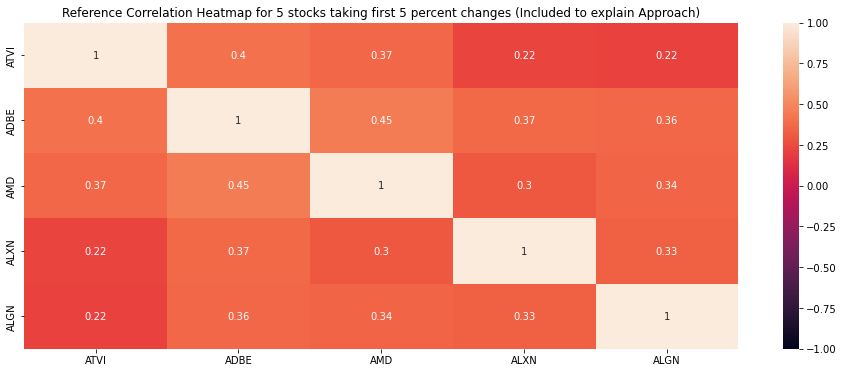

In [6]:
# sample heatmap for visual reference of correlation between stocks

df_corr_matrix = fin_matrix.iloc[:5,:5]
plt.figure(figsize=(16,6))
heatmap = sns.heatmap(df_corr_matrix,vmin=-1,vmax=1,annot=True)
heatmap.set_title('Reference Correlation Heatmap for 5 stocks taking first 5 percent changes (Included to explain Approach)')

In [7]:
def stock_selection (fin_matrix,m):
    sim_values = np.concatenate(fin_matrix.values)
    obj = np.array(list(sim_values) + [0]*len(fin_matrix))
    obj
    
    # creating blank constraint matrix
    A = np.zeros(((1+len(fin_matrix)+len(sim_values)),len(obj)))
    
    # first constraint
    A[0][len(sim_values):] = 1
    
    # second constraint
    for i in range(1,len(fin_matrix)+1):
        A[i][(i-1)*len(fin_matrix):(i*len(fin_matrix))] = 1
        
    # third constraint
    row = 1+len(fin_matrix)
    for i in range(0,len(fin_matrix)):
        for j in range(0,len(fin_matrix)):
            A[row][i*len(fin_matrix)+j] = 1
            A[row][len(sim_values)+j] = -1
            row+=1
            
    # defining sense and right hand side of constraints
    direction = ['='] * (len(fin_matrix)+1) + ['<'] * len(sim_values)
    b = np.array([m] + [1]*len(fin_matrix) + [0]*len(sim_values))
    
    # running the model and optimizing
    tspMod = gp.Model()
    tspMod_x = tspMod.addMVar(len(obj), vtype=['B']*len(obj)) 
    tspMod_con = tspMod.addMConstrs(A, tspMod_x, direction, b)
    tspMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)

    tspMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    tspMod.optimize()
    
    # creating dataframe with x output from gurobi
    x_output = pd.DataFrame(zip(fin_matrix.columns, tspMod.x[len(sim_values):]), columns=['stocks','chosen'])

    # selecting just the stocks that were picked as representatives
    selected_stocks = x_output[x_output['chosen'] == 1]
    return selected_stocks

    ss_list = selected_stocks.stocks.values.tolist()
    ss_list =  + ss_list
    return ss_list

In [8]:
# displaying the stocks selected
stock_selection(fin_matrix,5)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-23


,stocks,chosen
56,LBTYK,1.0
59,MXIM,1.0
63,MSFT,1.0
94,VRTX,1.0
98,XEL,1.0


In [9]:
m = len(stock_selection(fin_matrix,5))

In [10]:
ss_list = stock_selection(fin_matrix,m).stocks.values.tolist()
ss_list

['LBTYK', 'MXIM', 'MSFT', 'VRTX', 'XEL']

In [11]:
# obtaining the percent changes for the stocks selected
weights = st19.pct_change().dropna()
index_df = weights.iloc[:,:1]
ss_weights = weights.loc[:,ss_list]
weights = pd.concat([index_df,ss_weights], axis = 1)
weights

,NDX,LBTYK,MXIM,MSFT,VRTX,XEL
X,,,,,,
2019-01-03,-0.033602,-0.006280,-0.056845,-0.036788,-0.002133,-0.003940
2019-01-04,0.044824,0.068546,0.044004,0.046509,0.054785,0.009786
2019-01-07,0.010211,-0.042766,0.010388,0.001275,0.018240,-0.004330
2019-01-08,0.009802,-0.036122,-0.015026,0.007251,0.013307,0.011597
2019-01-09,0.007454,0.002959,0.027098,0.014300,0.023065,-0.007984
...,...,...,...,...,...,...
2019-12-23,0.002019,0.004617,-0.004213,0.000000,-0.003217,-0.017615
2019-12-24,0.000402,0.000919,-0.002604,-0.000191,0.002637,0.003913
2019-12-26,0.009058,-0.016988,0.006526,0.008197,-0.001406,-0.001114


In [12]:
# writing a function for obtaining the weights of stocks in the portfolio
def port_weights (weights):
    col_df = weights.iloc[: , 1:]
    col_names = list(col_df.columns)
    m = len(weights.columns) - 1
    a = np.array([1]*len(weights))                           # 1 decision variable each for the number of days
    b = np.array([0]*m)                                      # 1 decision variable each for the number of stocks to include in Fund
    obj2 = np.concatenate((a,b),axis=None)
    
    
    # setting the number of constraints and variables to define constraint matrix
    no_constraints = 2*len(weights)+1
    no_variables = len(obj2)
    A2 = np.zeros((no_constraints, no_variables))

    # setting the coefficients for the decision variables
    for i in range(0,int(no_constraints/2)):
        A2[i,i] = 1
               
    for i in range(0,int(no_constraints/2)):
        A2[i+int(no_constraints/2),i] = 1
               
    for i in range(0,len(weights)):
        stock_weights = weights.iloc[i,1:]
        A2[i,-m:] = stock_weights
               
    for i in range(0,len(weights)):
        stock_weights = weights.iloc[i,1:]
        A2[i+len(weights),-m:] = -stock_weights
    
    # adding constraint for all stock weights to add up to 1
    A2[no_constraints-1,-m:] = 1
               
    index_weights = weights.iloc[:,0].tolist()
 

    rhs = []
               
    for i in index_weights:
        rhs.append(i)

    for i in index_weights:
        j = -i
        rhs.append(j)
    rhs.append(1)                 

    direction2 = np.array(['>']*2*len(weights)+['='])
    
    # running the model and optimizing
    tspMod = gp.Model()
    tspMod_x = tspMod.addMVar(len(obj2), vtype=['C']*len(weights)+['C']*m)
    tspMod_con = tspMod.addMConstrs(A2, tspMod_x, direction2, rhs)
    tspMod.setMObjective(None,obj2,0,sense=gp.GRB.MINIMIZE)

    tspMod.Params.OutputFlag = 0 
    tspMod.optimize()
    
    w2019 = tspMod_x.x[-m:]

    df_2019 = pd.DataFrame(w2019).T
    df_2019.columns = [col_names]
    
    objval = tspMod.objval
    return df_2019 , w2019 , objval

In [13]:
# displaying the weights of stocks in the Fund
df_2019 , w2019, objval = port_weights(weights)
df_2019

,LBTYK,MXIM,MSFT,VRTX,XEL
0,0.048862,0.210388,0.580352,0.07119,0.089208


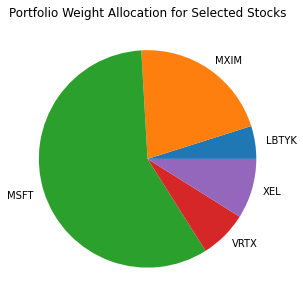

In [14]:
# Creating and displaying a pie chart with the selected stocks and respective portfolio weights
labels_list = ss_list
data = w2019

fig = plt.figure(figsize=(5,5))
plt.pie(data,labels=labels_list)
plt.title('Portfolio Weight Allocation for Selected Stocks')

plt.show()

# Question 2

In [15]:
# running 2 functions to get weights
m = len(stock_selection(fin_matrix,5))

ss_list = stock_selection(fin_matrix,m).stocks.values.tolist()

weights = st19.pct_change().dropna()
index_df = weights.iloc[:,:1]
ss_weights = weights.loc[:,ss_list]
weights = pd.concat([index_df,ss_weights], axis = 1)

df_2019 , w2019, objval = port_weights(weights)
df_2019

,LBTYK,MXIM,MSFT,VRTX,XEL
0,0.048862,0.210388,0.580352,0.07119,0.089208


In [16]:
# preparing 2020 data for evaluation
eval2020 = st20.pct_change().dropna()
index_2020 = eval2020.iloc[:,:1]
eval_weights = eval2020.loc[:,ss_list]
eval2020 = pd.concat([index_2020,eval_weights], axis = 1)
eval2020

,NDX,LBTYK,MXIM,MSFT,VRTX,XEL
X,,,,,,
2020-01-03,-0.008827,-0.016204,-0.017299,-0.012452,-0.006699,0.004809
2020-01-06,0.006211,0.015059,-0.018093,0.002585,0.027755,-0.001436
2020-01-07,-0.000234,-0.007881,0.022576,-0.009118,-0.001071,-0.002077
2020-01-08,0.007452,-0.043458,-0.000325,0.015928,0.032620,-0.000961
2020-01-09,0.008669,-0.024426,0.007308,0.012493,-0.003592,0.002244
...,...,...,...,...,...,...
2020-09-24,0.005828,0.003982,0.005573,0.012962,-0.002615,0.013295
2020-09-25,0.023371,0.015865,0.008775,0.022787,0.019192,0.021321
2020-09-28,0.019130,0.019522,0.037998,0.007795,-0.001678,0.005109


In [17]:
# calculating and displaying the total absolute error
total_error = 0
for k in range(len(eval2020)):
    ind_val = eval2020.iloc[k][0]
    ret_val = eval2020.iloc[k][ss_list].to_list()
    
    total_error += abs(ind_val - np.dot(w2019,ret_val))
total_error

0.8696699433741908

# Question 3

# 2020 Performance

In [18]:
# creating fund for different number of stocks and evaluating performance against 2020 data

n = len(fin_matrix.columns)
ranges = [x for x in range(10,n+1,10)]

total_error_list_2020 = []
no_stocks = []

results1st2020 = pd.DataFrame(columns=['m','error'])

for l in ranges:
    # running 2 functions to get weights
    m = len(stock_selection(fin_matrix,l))
    no_stocks.append(m)

    ss_list = stock_selection(fin_matrix,m).stocks.values.tolist()

    weights = st19.pct_change().dropna()
    index_df = weights.iloc[:,:1]
    ss_weights = weights.loc[:,ss_list]
    weights = pd.concat([index_df,ss_weights], axis = 1)

    df_2019 , w2019, objval = port_weights(weights)
    df_2019
    
    eval2020 = st20.pct_change().dropna()
    index_2020 = eval2020.iloc[:,:1]
    eval_weights = eval2020.loc[:,ss_list]
    eval2020 = pd.concat([index_2020,eval_weights], axis = 1)
    
    total_error = 0
    
    for k in range(len(eval2020)):
        ind_val = eval2020.iloc[k][0]
        ret_val = eval2020.iloc[k][ss_list].to_list()
    
        total_error += abs(ind_val - np.dot(w2019,ret_val))
    results1st2020.loc[l,'error'] = total_error
    results1st2020.loc[l,'m'] = m
    print('m = {}, total error is {}'.format(m, total_error))
    total_error_list_2020.append(total_error)
    #print(total_error)
    
print('where m represents the number of stocks selected')
results1st2020

m = 10, total error is 0.8313165184500251
m = 20, total error is 0.6523378586362023
m = 30, total error is 0.5490849328816374
m = 40, total error is 0.5873120559530017
m = 50, total error is 0.5811479442370265
m = 60, total error is 0.8194235991971988
m = 70, total error is 0.40249695463776525
m = 80, total error is 0.3864307853572664
m = 90, total error is 0.24758163037063843
m = 100, total error is 0.24994327434030078
where m represents the number of stocks selected


,m,error
10,10,0.831317
20,20,0.652338
30,30,0.549085
40,40,0.587312
50,50,0.581148
60,60,0.819424
70,70,0.402497
80,80,0.386431
90,90,0.247582
100,100,0.249943


In [19]:
print('Lowest Total Error for',no_stocks[total_error_list_2020.index(min(total_error_list_2020))],'stocks with Total Error =',min(total_error_list_2020))

Lowest Total Error for 90 stocks with Total Error = 0.24758163037063843


# 2019 Performance

In [20]:
# creating fund for different number of stocks and evaluating performance against 2020 data

n = len(fin_matrix.columns)
ranges = [x for x in range(10,n+1,10)]

total_error_list_2019 = []

results1st2019 = pd.DataFrame(columns=['m','error'])

for l in ranges:
    # running 2 functions to get weights
    m = len(stock_selection(fin_matrix,l))

    ss_list = stock_selection(fin_matrix,m).stocks.values.tolist()

    weights = st19.pct_change().dropna()
    index_df = weights.iloc[:,:1]
    ss_weights = weights.loc[:,ss_list]
    weights = pd.concat([index_df,ss_weights], axis = 1)

    df_2019 , w2019, objval = port_weights(weights)
    df_2019
    
    eval2019 = st19.pct_change().dropna()
    index_2019 = eval2019.iloc[:,:1]
    eval_weights = eval2019.loc[:,ss_list]
    eval2019 = pd.concat([index_2019,eval_weights], axis = 1)
    
    total_error = 0
    for k in range(len(eval2019)):
        ind_val = eval2019.iloc[k][0]
        ret_val = eval2019.iloc[k][ss_list].to_list()
    
        total_error += abs(ind_val - np.dot(w2019,ret_val))
    results1st2019.loc[l,'error'] = total_error
    results1st2019.loc[l,'m'] = m
    print('m = {}, total error is {}'.format(m, total_error))
    total_error_list_2019.append(total_error)
    #print(total_error)
    
print('where m represents the number of stocks selected')
results1st2019

m = 10, total error is 0.686533011145812
m = 20, total error is 0.47883578791133574
m = 30, total error is 0.4180147550230183
m = 40, total error is 0.37051722255520575
m = 50, total error is 0.33254009291547576
m = 60, total error is 0.34488997906451385
m = 70, total error is 0.169823718275309
m = 80, total error is 0.1476825280009613
m = 90, total error is 0.05377918984547229
m = 100, total error is 0.044910816393603885
where m represents the number of stocks selected


,m,error
10,10,0.686533
20,20,0.478836
30,30,0.418015
40,40,0.370517
50,50,0.33254
60,60,0.34489
70,70,0.169824
80,80,0.147683
90,90,0.053779
100,100,0.044911


In [21]:
print('Lowest Total Error for',no_stocks[total_error_list_2019.index(min(total_error_list_2019))],'stocks with Total Error =',min(total_error_list_2019))

Lowest Total Error for 100 stocks with Total Error = 0.044910816393603885


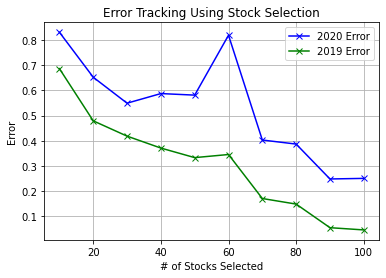

In [22]:
plt.plot(results1st2020['m'], results1st2020['error'], marker = 'x', color = 'blue', label = '2020 Error')
plt.plot(results1st2019['m'], results1st2019['error'], marker = 'x', color = 'green', label = '2019 Error')
plt.title('Error Tracking Using Stock Selection')
plt.legend(loc='best')
plt.xlabel("# of Stocks Selected")
plt.ylabel("Error")
plt.grid()
plt.show()

## Question 4 - Alternative Big M Method

In [23]:
# creating percent change dataframe for all the stocks in our data
weights2 = st19.pct_change().dropna()

In [24]:
# 

def port_weights2(m):
    M = 1
    stocks = len(st19.columns)-1
    col_df = weights2.iloc[: , 1:]
    col_names = list(col_df.columns)
    # m = len(weights.columns) - 1
    a = np.array([1]*len(weights2))                         # continuous variables - 1 for each day
    b = np.array([0]*(stocks))                              # binary variables - 1 for each stock
    c = np.array([0]*(stocks))                              # continuous variables - 1 weight for each stock
    obj3 = np.concatenate((a,b,c),axis=None)

    no_constraints = 2*len(weights2)+stocks+2
    no_variables = len(obj3)
    A3 = np.zeros((no_constraints, no_variables))

    for i in range(0,len(weights2)):
        A3[i,i] = 1

    for i in range(0,len(weights2)):
        A3[i+len(weights2),i] = 1

    for i in range(0,len(weights2)):
        stock_weights = weights2.iloc[i,1:]
        A3[i,-stocks:] = stock_weights

    for i in range(0,len(weights2)):
        stock_weights = weights2.iloc[i,1:]
        A3[i+len(weights2),-stocks:] = -stock_weights

    for i in range(0,stocks):
        A3[i+(2*len(weights2)),i+len(weights2)] = -M

    for i in range(0,stocks):
        A3[i+(2*len(weights2)),no_variables-stocks+i] = 1


    A3[no_constraints-2,-stocks:] = 1

    for i in range(0,stocks):
        A3[no_constraints-1,i+len(weights2)] = 1


    index_weights = weights2.iloc[:,0].tolist()


    rhs = []

    for i in index_weights:
        rhs.append(i)

    for i in index_weights:
        j = -i
        rhs.append(j)

    for i in range(0,stocks):
        rhs.append(0)

    rhs.append(1)
    rhs.append(m) 

    direction3 = np.array(['>']*2*len(weights2)+['<']*stocks+['=']*2)

    # running the model and optimizing
    tspMod = gp.Model()
    tspMod_x = tspMod.addMVar(len(obj3), vtype=['C']*len(weights2)+['B']*stocks+['C']*stocks)
    tspMod_con = tspMod.addMConstrs(A3, tspMod_x, direction3, rhs)
    tspMod.setMObjective(None,obj3,0,sense=gp.GRB.MINIMIZE)

    tspMod.Params.OutputFlag = 0 
    tspMod.Params.TimeLimit = STOP_TIME       # tell gurobi to shut up!!
    tspMod.optimize()
    
    no_stocks_selected = m
    #stocks_selected = tspMod_x.x[len(weights):(len(weights)+stocks)]
    weights_stocks_selected = tspMod_x.x[-stocks:]
    
    
    return weights_stocks_selected
  

In [25]:
# Checking if the csv file output already exists
# If it exists, read in the output csv file and use it for performance analysis
if file_exists('Final_output.csv'):
    Final_df = pd.read_csv('Final_output.csv')
    
#If Output does not exist, then run the optimization problem again and get the output downloaded in csv file format
else:
    dfIndex = []
    dfIndex.append('Number_of_stocks')

    for i in range(1,len(st19.columns)):
        dfIndex.append(st19.columns[i])

    Final_df = pd.DataFrame(columns=dfIndex)
    Final_df
    
    m = 5

    stock_weight_list = []
    input_row = []

    stock_weight_list = port_weights2(m)

    input_row.append(m)

    for i in stock_weight_list:
        input_row.append(i)

    Final_df.loc[len(Final_df)] = input_row
    
    total_col = len(st19.columns)

    for m in ranges:
        input_row2 = []
        input_row2.append(m)
        stock_weight_list2 = []
        stock_weight_list2 = port_weights2(m)
        for i in stock_weight_list2:
            input_row2.append(i)
        Final_df.loc[len(Final_df)] = input_row2
    
    Final_df.to_csv('Final_output.csv',header=True)

In [26]:
Final_df

,Unnamed: 0,Number_of_stocks,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
0,0,5.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.250123,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,10.0,0.000000,0.000000,0.000000,0.000000,0.0,0.093503,0.000000,0.125808,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.041476,0.000000,0.000000,0.000000,0.000000
2,2,20.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.094677,0.103361,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.014530,0.000000,0.000000,0.000000,0.017610
3,3,30.0,0.009001,0.021307,0.000000,0.000000,0.0,0.085988,0.000000,0.092432,...,0.000000,0.010545,0.000000,0.028794,0.000000,0.000000,0.000000,0.000000,0.000000,0.015567
4,4,40.0,0.000000,0.022593,0.006223,0.000000,0.0,0.084434,0.000000,0.101973,...,0.000000,0.005149,0.000000,0.017183,0.000000,0.010026,0.000000,0.000000,0.000000,0.008502
5,5,50.0,0.005319,0.023629,0.004325,0.000000,0.0,0.083570,0.000000,0.098042,...,0.000000,0.004656,0.000000,0.000000,0.000000,0.008902,0.000000,0.000000,0.000000,0.007036
6,6,60.0,0.000000,0.016210,0.002794,0.000000,0.0,0.086696,0.000000,0.095965,...,0.000000,0.004711,0.010804,0.000000,0.006922,0.010050,0.003977,0.000000,0.000000,0.007148
7,7,70.0,0.003455,0.018230,0.003072,0.000000,0.0,0.088768,0.000000,0.097141,...,0.000000,0.004624,0.008333,0.000000,0.008593,0.008829,0.002392,0.000000,0.000000,0.004731
8,8,80.0,0.003119,0.017845,0.003566,0.001275,0.0,0.057147,0.027985,0.096184,...,0.000000,0.004054,0.007078,0.005699,0.007782,0.009250,0.002624,0.000000,0.000000,0.005633
9,9,90.0,0.004279,0.017198,0.004016,0.002467,0.0,0.056237,0.030318,0.095571,...,0.000431,0.003832,0.006205,0.006624,0.008927,0.009159,0.002540,0.000016,0.003557,0.005427


In [27]:
weights_final = pd.read_csv('Final_output.csv', index_col = 0)
ranges = weights_final.Number_of_stocks.values.tolist()
ranges

[5.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]

In [28]:
weights_final.drop(weights_final.columns[[0]], axis=1, inplace=True)

In [29]:
eval2020

,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
X,,,,,,,,,,,,,,,,,,,,,
2020-01-03,-0.008827,0.000341,-0.007834,-0.010183,-0.013260,-0.011421,-0.005231,-0.004907,-0.012139,-0.006789,...,-0.021369,-0.017207,0.021095,0.009727,-0.006699,0.000000,0.005852,-0.015392,0.004809,-0.023020
2020-01-06,0.006211,0.018238,0.005726,-0.004321,0.001598,0.019398,0.026654,0.024657,0.014886,0.007674,...,-0.013543,0.003118,0.009259,0.002294,0.027755,0.008632,0.006234,-0.019192,-0.001436,-0.020844
2020-01-07,-0.000234,0.010043,-0.000959,-0.002893,0.002533,-0.009864,-0.001932,-0.000624,0.002092,-0.009405,...,0.045951,0.008528,0.002318,0.008369,-0.001071,-0.005034,0.020414,0.067698,-0.002077,0.022830
2020-01-08,0.007452,-0.007623,0.013438,-0.008705,0.016191,0.010386,0.007118,0.007880,-0.007809,0.000756,...,-0.012323,0.019400,0.004626,0.009207,0.032620,-0.058357,0.033304,0.014484,-0.000961,-0.002815
2020-01-09,0.008669,-0.009018,0.007636,0.023834,0.019893,0.036853,0.010498,0.011044,0.004799,0.002980,...,0.006781,0.021318,0.023169,0.009638,-0.003592,-0.020598,0.004309,-0.000291,0.002244,0.023493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-24,0.005828,-0.005491,-0.005782,0.014586,-0.003647,0.011546,0.009557,0.009242,0.006644,-0.009357,...,0.003254,-0.006681,0.009343,0.000847,-0.002615,-0.000856,0.006268,-0.035714,0.013295,0.017679
2020-09-25,0.023371,0.016188,0.025894,0.029544,0.021514,0.019398,0.011386,0.011671,0.024949,0.014564,...,0.086486,0.005752,0.017672,0.023190,0.019192,0.011419,0.033974,0.025047,0.021321,0.013534
2020-09-28,0.019130,0.011978,0.018196,0.018191,-0.009875,0.015507,0.013620,0.013537,0.025498,0.013165,...,0.061360,0.041092,-0.004183,0.017536,-0.001678,0.018064,0.021133,0.003899,0.005109,0.034380


In [30]:
eval2020 = st20.pct_change().dropna()
eval2019 = st19.pct_change().dropna()

# 2020 Performance

In [31]:
# calculating performance for 2020
total_error = 0

resultsM2020 = pd.DataFrame(columns=['m','error'])

for j in range(len(weights_final)):
    current_weights = weights_final.iloc[j].to_numpy()
    for i in range(len(eval2020)):
        ind_val = eval2020.iloc[i][0]
        ret_val = eval2020.iloc[i][1:].to_list()
    
        total_error += abs(ind_val - np.dot(current_weights,ret_val))
    resultsM2020.loc[j,'error'] = total_error
    #print('m = {}, total error is {}'.format(j, total_error))
    total_error = 0
resultsM2020['m'] = ranges
resultsM2020

,m,error
0,5.0,0.591398
1,10.0,0.548939
2,20.0,0.384032
3,30.0,0.355484
4,40.0,0.299958
5,50.0,0.286697
6,60.0,0.250075
7,70.0,0.251591
8,80.0,0.249143
9,90.0,0.250194


# 2019 Performance

In [32]:
# calculating performance for 2019

total_error = 0

resultsM2019 = pd.DataFrame(columns=['m','error'])

for j in range(len(weights_final)):
    current_weights = weights_final.iloc[j].to_numpy()
    for i in range(len(eval2019)):
        ind_val = eval2019.iloc[i][0]
        ret_val = eval2019.iloc[i][1:].to_list()
    
        total_error += abs(ind_val - np.dot(current_weights,ret_val))
    resultsM2019.loc[j,'error'] = total_error
    #print('m = {}, total error is {}'.format(j, total_error))
    total_error = 0
resultsM2019['m'] = ranges
resultsM2019

,m,error
0,5.0,0.499259
1,10.0,0.290137
2,20.0,0.163468
3,30.0,0.110359
4,40.0,0.080353
5,50.0,0.061113
6,60.0,0.052043
7,70.0,0.047688
8,80.0,0.045227
9,90.0,0.044911


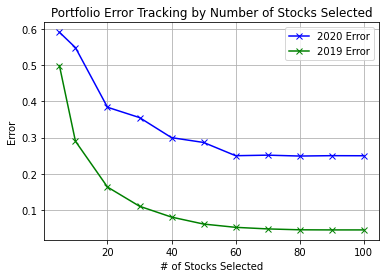

In [33]:
# displaying the results

plt.plot(resultsM2020['m'], resultsM2020['error'], marker = 'x', color = 'blue', label = '2020 Error')
plt.plot(resultsM2019['m'], resultsM2019['error'], marker = 'x', color = 'green', label = '2019 Error')
plt.title('Portfolio Error Tracking by Number of Stocks Selected')
plt.legend(loc='best')
plt.xlabel("# of Stocks Selected")
plt.ylabel("Error")
plt.grid()
plt.show()